### **Importing the required libraries**

In [1]:
#!pip install -q git+https://github.com/huggingface/transformers.git

In [2]:
!pip install -q datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.9 MB/s eta 0:00:00


In [3]:
!pip install transformers==4.27.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [4]:
import torch
import pandas as pd
from PIL import Image
from datasets import load_metric
from torch.utils.data import Dataset
from transformers import TrOCRProcessor
from transformers import default_data_collator
from transformers import VisionEncoderDecoderModel
from sklearn.model_selection import train_test_split
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

### **Preparing the Data**

In [5]:
# The dataset is currently stored on my Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
dir =  '/content/drive/MyDrive/NewData5417' #/content/drive/MyDrive/data-10373'
#dir = '/content/drive/MyDrive/bengali-5417'
#dir = '/content/drive/MyDrive/gujarati-5158'

In [7]:
df = pd.read_csv(dir + '/metadata.csv', header=None)

df.rename(columns={0: "image_name", 1: "char_seq"}, inplace=True)
#del df[2]
#del df[3]
#del df[4]

# REMOVING a lot of points right now
#df.drop(df.tail(3700).index, inplace = True)

df.head()

,image_name,char_seq,2,3,4
0,93204-0-0.png,पश्चिमी,4,2,1
1,93204-0-1.png,क्षेत्र,4,1,2
2,93204-0-2.png,या,1,1,0
3,93204-0-3.png,षीयू,2,2,0
4,93204-0-4.png,तीसरी,3,2,0


In [8]:
x = df.iloc[[0]]['char_seq']

In [9]:
y = x[0]

In [10]:
print(y)

पश्चिमी


In [11]:
train_df, test_df = train_test_split(df, test_size=0.15)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [12]:
class HindiData(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        image_name = self.df['image_name'][i]
        char_seq = self.df['char_seq'][i]

        image = Image.open(self.root_dir + image_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        labels = self.processor.tokenizer(char_seq,padding="max_length",max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function

        final_labels = [None]*len(labels)
        for i in range(len(final_labels)):
          if labels[i] == self.processor.tokenizer.pad_token_id:
            final_labels[i] = -100
          else:
            final_labels[i] = labels[i]

        #labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(final_labels)}
        return encoding

In [13]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [14]:
root_dir = dir + '/chips/'

train_dataset = HindiData(root_dir= root_dir, df=train_df,processor=processor)
eval_dataset = HindiData(root_dir= root_dir, df=test_df, processor=processor)

In [15]:
print("Training samples:", len(train_dataset), ", Validation samples:",len(eval_dataset) )

Training samples: 4604 , Validation samples: 813


### **Training (Fine-tuning) the model**

In [16]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [18]:
args = Seq2SeqTrainingArguments(
    output_dir="./", # where predictions and checkpoints should be written
    predict_with_generate=True,
    evaluation_strategy="steps",
    logging_steps=2,
    eval_steps=200, # used to be 200
    gradient_accumulation_steps= 4, # was originally 4
    gradient_checkpointing=True,
    fp16=True, # False did not result in better accuracy
    learning_rate = 0.00005
)

In [19]:
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    tokenizer= processor.tokenizer,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
200,0.324500,0.528356
400,0.164400,0.186480


TrainOutput(global_step=432, training_loss=0.7803671049575011, metrics={'train_runtime': 2986.737, 'train_samples_per_second': 4.624, 'train_steps_per_second': 0.145, 'total_flos': 1.2222175964527854e+19, 'train_loss': 0.7803671049575011, 'epoch': 3.0})

### **Evaluation**

In [20]:
cer_value = load_metric("cer")
def char_error_rate(predictions):
    pred_ids = predictions.predictions
    labels_ids = predictions.label_ids

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_value.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

<ipython-input-20-924994b9f9ab>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_value = load_metric("cer")


In [21]:
predictions = trainer.predict(eval_dataset)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1201: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


In [22]:
cer = char_error_rate(predictions)
# CER for fp32 - 5.74% on smaller dataset
# CER for fp16 - 3.51677% on smaller dataset with 2.5e-5
# CER for fp16 - 5.07256% on bigger dataset (10373) with 2.5e-5
# CER for fp16 - 4.26466% on bigger dataset (10373) with 2.5e-5 and 6 grad acc steps instead of 4

# CER for bengali dataset - 1332 samples - 2.5e-5, 4 grad acc, 200 eval steps : 71.5%
# CER for bengali dataset - 5417 samples - 5e-5, 4 grad acc, 200 eval steps : 11.84%
# CER for gujarati dataset - 5158 samples - 5e-5, 4 grad acc, 200 eval steps : 16.356%

In [23]:
cer

{'cer': 0.05035405192761605}

### **Testing the model on 1 image**

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['image_name'][22]).convert("RGB")

In [ ]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 384, 384])


In [ ]:
pixel_values = pixel_values.cuda()
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

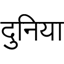

In [ ]:
image

In [ ]:
print(generated_text)

दुनिया


### **Saving the model**

In [ ]:
# trainer.save_model('/content/drive/MyDrive/Capstone_models/CER-SOMETHING_P-printed_M-stage1_Entire')
trainer.save_model('/content/drive/MyDrive/Capstone_models/2.5e05-10GradAccSteps-LR-largeData-fp16-Model')

### **Importing and using a saved version of the model**

In [ ]:
newmodel = VisionEncoderDecoderModel.from_pretrained('/content/drive/MyDrive/Capstone_models/CER-23_P-printed_M-printed_dropped-3700')

pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = newmodel.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


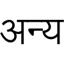

In [ ]:
image

In [ ]:
print(generated_text)

['अ', 'न', '्']
